In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
final = pd.read_csv('./Clean/modified_flyball.csv', dtype={'game_state': str})
routes = pd.read_parquet('./Clean/mapped_routes.parquet')
p1_y_m = pickle.load(open('./CLean/p1_y.pkl', 'rb'))
p2_y_m = pickle.load(open('./CLean/p2_y.pkl', 'rb'))


In [4]:
final['p1_y_pred'] = p1_y_m.predict(final[['launch_angle', 'exit_velocity', 'spray_angle', 'field_y']])
final['p2_y_pred'] = p2_y_m.predict(final[['launch_angle', 'exit_velocity', 'spray_angle', 'p1_y_pred']])


In [5]:
final[['p1_y', 'p2_y', 'p1_y_pred', 'p2_y_pred']].describe()

,p1_y,p2_y,p1_y_pred,p2_y_pred
count,4494.000000,4494.000000,4494.000000,4494.000000
mean,270.842706,269.460939,270.951904,269.345947
std,33.178355,46.198911,30.018034,37.694851
min,128.048648,117.258565,204.719238,153.474503
25%,245.035236,238.772239,246.062054,240.518970
50%,262.703294,266.310956,261.436844,268.297089
75%,301.332661,304.061216,300.040611,298.583305
max,383.725142,412.324978,333.848114,357.039581


In [7]:
def cubic_bezier_curve(df):
    bezier_x = []
    bezier_y = []
    
    p0 = (df['field_x_int'].iloc[0], df['field_y_int'].iloc[0])
    p1 = (df['p1_x'].iloc[0], df['p1_y_pred'].iloc[0])
    p2 = (df['p2_x'].iloc[0], df['p2_y_pred'].iloc[0])
    p3 = (df['field_x_int'].iloc[-1], df['field_y_int'].iloc[-1])

    t_range = np.linspace(0, 1, 100)

    x_p = []
    y_p = []

    for t in t_range:
        x = (1 - t)**3 * p0[0] + 3 * (1 - t)**2 * t * p1[0] + 3 * (1 - t) * t**2 * p2[0] + t**3 * p3[0]
        y = (1 - t)**3 * p0[1] + 3 * (1 - t)**2 * t * p1[1] + 3 * (1 - t) * t**2 * p2[1] + t**3 * p3[1]
        x_p.append(x)
        y_p.append(y)

    bezier_x.extend(x_p)
    bezier_y.extend(y_p)
    
    return bezier_x, bezier_y

In [8]:
plot = final.merge(routes[['game_str', 'play_id', 'field_x_int', 'field_y_int', 'linear_x', 'linear_y']], on = ['game_str', 'play_id'], how='left')


In [43]:
final.columns

Index(['game_str', 'play_id', 'at_bat', 'play_per_game', 'end_time',
       'player_position', 'event_code', 'almost_caught', 'start_time',
       'player_position_hit', 'inning', 'game_state', 'player_id', 'field_x',
       'field_y', 'handedness', 'ball_position_x', 'ball_position_y',
       'ball_position_z', 'exit_velocity', 'launch_angle', 'field_end_x',
       'field_end_y', 'actual_distance', 'max_speed', 'mean_speed', 'p1_x',
       'p1_y', 'p2_x', 'p2_y', 'initial_angle', 'spray_angle', 'straight_line',
       'route_efficiency', 'max_player_speed', 'actual_time', 'league',
       'handedness_encode', 'p1_y_pred', 'p2_y_pred', 'expected_distance',
       'n_route_efficiency', 'route_chng'],
      dtype='object')

(0.0, 400.0)

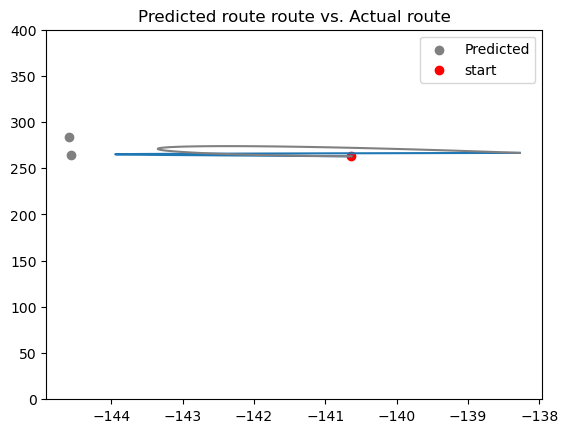

In [39]:
game = '1884_120_Vis2AT_Home2A'
play_id = 243

plot_test = plot.query(f"game_str == '{game}' & play_id == {play_id}")
coords = plot.query(f"game_str == '{game}' & play_id == {play_id}")
x, y = cubic_bezier_curve(plot_test)
plt.plot(plot_test['field_x_int'], plot_test['field_y_int']) # actual line
plt.plot(x, y, color = 'grey') # expected line
#plt.plot(plot_test['linear_x'], plot_test['linear_y']) # straight line

# plt.scatter(coords['p1_x'].iloc[0], coords['p1_y'].iloc[0], c='blue')
# plt.scatter(coords['p2_x'].iloc[0], coords['p2_y'].iloc[0], c='blue')
plt.scatter(coords['p1_x'].iloc[0], coords['p1_y_pred'].iloc[0], c='grey', label = 'Predicted')
plt.scatter(coords['p2_x'].iloc[0], coords['p2_y_pred'].iloc[0], c='grey')
plt.scatter(plot_test['field_x_int'].iloc[0], plot_test['field_y_int'].iloc[0], color='r', label = 'start')
plt.legend(loc= 'best')
plt.title('Predicted route route vs. Actual route')
#plt.xlim(-20, 20)

plt.ylim(0, 400) # Bezier curve

In [20]:
values = []
for (game_str, play_id), play in tqdm(plot.groupby(['game_str', 'play_id']), desc = 'Extracting distance'):
    x, y = cubic_bezier_curve(play)
    x_diff = np.diff(np.array(x))
    y_diff = np.diff(np.array(y))
    stepwise_diff = np.sqrt(x_diff**2 + y_diff ** 2)
    distance = np.sum(stepwise_diff)
    
    values.append({'game_str': game_str, 'play_id': play_id, 'expected_distance' : distance})
    

Extracting distance: 100%|████████████████| 4491/4491 [00:01<00:00, 3380.89it/s]


In [21]:
derived = pd.DataFrame(values)

final = final.merge(derived, on = ['game_str', 'play_id'], how = 'left')

In [22]:
final['n_route_efficiency'] = final['expected_distance'] / final['actual_distance']

In [24]:
final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,straight_line,route_efficiency,max_player_speed,actual_time,league,handedness_encode,p1_y_pred,p2_y_pred,expected_distance,n_route_efficiency
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,23.111248,0.553842,18.968681,5.50,Home1A,1,307.340851,319.669586,23.387535,0.560463
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,63.547674,0.879348,18.278859,5.15,Home1A,0,240.415726,215.724991,67.384952,0.932447
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,73.705410,0.831447,12.877761,3.55,Home1A,0,307.367798,276.698273,71.575377,0.807418
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,61.705056,0.963687,12.877761,4.05,Home1A,1,270.413025,288.862885,62.489751,0.975942
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,103.767242,0.986064,18.625452,4.50,Home1A,1,240.020920,264.587097,103.392230,0.982500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,1,8160659,BA,...,76.262876,0.883119,12.154987,3.80,Home4A,0,233.579620,228.573212,82.280565,0.952803
4490,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,64.031032,0.921266,16.983263,5.45,Home4A,1,261.418884,281.564514,63.979744,0.920528
4491,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,54.535328,0.971060,17.721751,5.80,Home4A,1,304.144592,313.857727,55.478833,0.987860
4492,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,43.112018,0.944617,12.154987,3.05,Home4A,1,257.659790,263.371521,46.799652,1.025416


In [25]:
final.groupby('game_state')['n_route_efficiency'].mean()

game_state
000    0.885006
001    0.814452
010    0.814980
011    0.817863
100    0.828440
101    0.826567
110    0.829801
111    0.847675
Name: n_route_efficiency, dtype: float64

In [26]:
final.groupby('game_state')['route_efficiency'].mean()

game_state
000    0.828879
001    0.742843
010    0.759080
011    0.751785
100    0.756794
101    0.760520
110    0.766139
111    0.775189
Name: route_efficiency, dtype: float64

# TODO:
* Histogram of Route efficiencies. Ours vs. straight line.
* Find where they do well situationally with route efficiency.
* Find run value for the route efficiency. Average run value from 1 to 2 outs 2 to 3. Average for one play based on out situation.
* Test the route efficiency on one control point. See how they differ.

In [27]:
final.groupby('league')['n_route_efficiency'].mean()

league
Home1A    0.869192
Home2A    0.857429
Home3A    0.875290
Home4A    0.848656
Name: n_route_efficiency, dtype: float64

In [28]:
final.groupby('league')['route_efficiency'].mean()

league
Home1A    0.806323
Home2A    0.792834
Home3A    0.815799
Home4A    0.794447
Name: route_efficiency, dtype: float64

In [35]:
final[final['player_id'] < 1000].groupby('player_id').agg(
    efficiency=('n_route_efficiency', 'mean'), 
    count=('at_bat', 'count'),
    league = ('league', 'first')
).sort_values(by='efficiency', ascending=False).head(10)


,efficiency,count,league
player_id,,,
557.0,1.176517,3,Home2A
835.0,0.944920,1,Home4A
383.0,0.933452,13,Home4A
467.0,0.894366,30,Home4A
651.0,0.890702,135,Home2A
547.0,0.886121,26,Home3A
475.0,0.882825,129,Home3A
634.0,0.882079,11,Home4A
334.0,0.880369,2,Home3A


In [153]:
final[final['player_id'] < 1000].groupby('player_id').agg(
    efficiency=('route_efficiency', 'mean'), 
    count=('at_bat', 'count')
).sort_values(by='efficiency', ascending=False).head(10)


,efficiency,count
player_id,,
383.0,0.891687,13
835.0,0.865049,1
423.0,0.856352,8
334.0,0.855153,2
467.0,0.852433,30
475.0,0.843348,129
409.0,0.840921,13
594.0,0.839221,37
651.0,0.836625,135


In [30]:
final.query('n_route_efficiency > 1.1').sort_values(by = 'n_route_efficiency')[['actual_distance', 'straight_line', 'expected_distance', 
                                                                             'n_route_efficiency', 'route_efficiency']]

,actual_distance,straight_line,expected_distance,n_route_efficiency,route_efficiency
86,67.038798,66.081976,73.823165,1.101201,0.985727
3746,43.204428,39.170613,47.626540,1.102353,0.906634
553,59.637383,57.370907,65.756133,1.102599,0.961996
639,94.747960,91.768028,104.769141,1.105767,0.968549
307,69.940898,64.171270,77.348759,1.105916,0.917507
...,...,...,...,...,...
3021,23.308699,20.838059,37.699713,1.617410,0.894004
809,29.836531,24.857342,50.665717,1.698110,0.833118
2825,19.304068,13.572168,33.030150,1.711046,0.703073
1068,8.710983,7.487987,16.812478,1.930032,0.859603


In [38]:
final['route_chng'] = final['n_route_efficiency'] - final['route_efficiency']

final.sort_values(by='route_chng', ascending = False)[['game_str', 'play_id',
                                                       'n_route_efficiency', 'route_efficiency', 
                                                       'route_chng']].head(10)


,game_str,play_id,n_route_efficiency,route_efficiency,route_chng
3930,1884_120_Vis2AT_Home2A,243,2.068445,0.532788,1.535657
3493,1884_107_Vis3AR_Home3A,43,1.215382,0.075846,1.139536
1005,1883_041_Vis3AE_Home3A,7,1.239301,0.168187,1.071114
1068,1883_043_Vis3AF_Home3A,336,1.930032,0.859603,1.070429
2825,1884_076_Vis1AU_Home1A,261,1.711046,0.703073,1.007973
4228,1884_132_Vis2AV_Home2A,164,1.580528,0.650744,0.929784
809,1883_035_Vis2AC_Home2A,246,1.698110,0.833118,0.864992
1385,1884_011_Vis2AF_Home2A,29,1.430845,0.596517,0.834327
2992,1884_085_Vis3AP_Home3A,14,1.067521,0.281768,0.785753
3021,1884_086_Vis3AP_Home3A,344,1.617410,0.894004,0.723406


In [41]:
final.describe()

,play_id,at_bat,play_per_game,end_time,almost_caught,start_time,inning,player_id,field_x,field_y,...,straight_line,route_efficiency,max_player_speed,actual_time,handedness_encode,p1_y_pred,p2_y_pred,expected_distance,n_route_efficiency,route_chng
count,4494.000000,4314.000000,4494.000000,4.494000e+03,4494.000000,4.494000e+03,4494.000000,3975.000000,4494.000000,4494.000000,...,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000
mean,142.790387,38.090867,143.972630,4.976326e+06,0.126168,4.971829e+06,4.641077,3133.340629,-0.116502,271.198753,...,57.414763,0.802421,13.491838,4.496323,0.520694,270.951904,269.345947,60.938927,0.862531,0.060110
std,86.128808,22.443098,86.783125,4.413941e+06,0.332076,4.413938e+06,2.656290,3082.873046,98.021608,30.189294,...,25.822979,0.170603,3.324930,1.087647,0.499627,30.018034,37.694851,25.897797,0.158736,0.094248
min,1.000000,0.000000,1.000000,1.087300e+04,0.000000,6.323000e+03,0.000000,334.000000,-174.922800,200.643000,...,0.559089,0.017571,2.221955,2.150000,0.000000,204.719238,153.474503,4.488772,0.115393,-0.122730
25%,72.000000,19.000000,72.000000,2.305780e+06,0.000000,2.300630e+06,2.000000,537.000000,-113.557125,245.828175,...,38.274418,0.737909,11.061228,3.600000,0.000000,246.062054,240.518970,41.092385,0.796205,0.010415
50%,137.000000,37.000000,138.000000,4.566242e+06,0.000000,4.561492e+06,5.000000,975.000000,-6.057450,261.989250,...,56.312292,0.854473,12.877761,4.500000,1.000000,261.436844,268.297089,59.353300,0.899668,0.035581
75%,210.750000,56.000000,212.000000,7.254698e+06,0.000000,7.251792e+06,7.000000,5419.000000,117.402825,301.015350,...,75.157968,0.922224,16.118212,5.379000,1.000000,300.040611,298.583305,78.548594,0.964250,0.079123
max,429.000000,106.000000,431.000000,8.749607e+07,1.000000,8.749202e+07,12.000000,9957.000000,176.677200,348.089400,...,151.203139,0.997705,20.883444,7.750000,1.000000,333.848114,357.039581,158.921831,2.068445,1.535657


# Upload csv file of this!!!

In [42]:
final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,route_efficiency,max_player_speed,actual_time,league,handedness_encode,p1_y_pred,p2_y_pred,expected_distance,n_route_efficiency,route_chng
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,0.553842,18.968681,5.50,Home1A,1,307.340851,319.669586,23.387535,0.560463,0.006621
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,0.879348,18.278859,5.15,Home1A,0,240.415726,215.724991,67.384952,0.932447,0.053099
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,0.831447,12.877761,3.55,Home1A,0,307.367798,276.698273,71.575377,0.807418,-0.024028
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,0.963687,12.877761,4.05,Home1A,1,270.413025,288.862885,62.489751,0.975942,0.012255
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,0.986064,18.625452,4.50,Home1A,1,240.020920,264.587097,103.392230,0.982500,-0.003564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,1,8160659,BA,...,0.883119,12.154987,3.80,Home4A,0,233.579620,228.573212,82.280565,0.952803,0.069684
4490,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,0.921266,16.983263,5.45,Home4A,1,261.418884,281.564514,63.979744,0.920528,-0.000738
4491,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,0.971060,17.721751,5.80,Home4A,1,304.144592,313.857727,55.478833,0.987860,0.016800
4492,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,0.944617,12.154987,3.05,Home4A,1,257.659790,263.371521,46.799652,1.025416,0.080799
